In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np

In [2]:
train_df = pd.read_csv("train.csv")
train_df.head()



,Score,Text
0,5,I received this product early from the seller!...
1,5,*****<br />Numi's Collection Assortment Melang...
2,5,"I was very careful not to overcook this pasta,..."
3,5,Buying this multi-pack I was misled by the pic...
4,5,These bars are so good! I loved them warmed up...


In [3]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM

# Preprocessing

In [4]:
VOCAB_SIZE = 10000  # Number of unique words to keep
SEQUENCE_LENGTH = 100  # Fixed length of input sequences

In [7]:
X_train = train_df['Text'].values
Y_train = train_df['Score'].values

In [8]:
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQUENCE_LENGTH  # Ensures uniform length
)

# Fit the TextVectorization layer to the text data
encoder.adapt(X_train)

In [9]:
vocab = np.array(encoder.get_vocabulary())
print(vocab[:20])  # Display the first 20 words

['' '[UNK]' 'the' 'i' 'and' 'a' 'to' 'it' 'of' 'is' 'this' 'in' 'for' 'my'
 'that' 'but' 'with' 'have' 'you' 'not']


In [11]:
# Sample text to test the encoder
sample_text = "This is a sample review."

# Use the encoder to transform the text into integers
encoded_text = encoder(tf.constant([sample_text]))

# Display the result
print(encoded_text.numpy())

[[  10    9    5 1073  378    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]]


In [12]:
X_train_vectorized = encoder(X_train)

# Train-Val Split to check for overfitting

In [14]:
import numpy as np
from sklearn.model_selection import train_test_split

# Ensure X_train_vectorized is a NumPy array
X_train_vectorized_np = X_train_vectorized.numpy() if isinstance(X_train_vectorized, tf.Tensor) else X_train_vectorized

# Split data into training and validation sets (80% training, 20% validation)
X_train, X_val, Y_train, Y_val = train_test_split(
    X_train_vectorized_np, Y_train, test_size=0.2, random_state=42
)


# Check if text is preprocessed properly

In [16]:
# Check the shape of X_train and X_val
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_val: {X_val.shape}")

# Print the first few tokenized sequences from X_train
print(f"Sample of tokenized X_train (first 3 samples):\n{X_train[:3]}")

# Print the first few tokenized sequences from X_val
print(f"Sample of tokenized X_val (first 3 samples):\n{X_val[:3]}")


Shape of X_train: (247304, 100)
Shape of X_val: (61827, 100)
Sample of tokenized X_train (first 3 samples):
[[   3   35  155    6  218   14    2  138 1679 5944  378    9   19   81
    18  265  136  214    8   33    2   78    8 2140   10  852 1644 6691
     4   14   73  117   46 2589   36   18  440   73  378  109 1261  128
   194  552   33   28  356  364    9  538   12    2 3904    2 6370 6565
    11    2  393    4 1767 1535  175   14   36  374 1185   21 2657  214
    32    2    1   24    2  532   59   71 7527  112  839    7  322   19
   763   26   46   37   96 2542   73  117   15  285   77  964   19  189
     7 1750]
 [  51  120    2  386 1354   26   14   51  130   99 1634  172   51   55
    29   42   23   21  188    6   72   87   40  296  718   51  211   53
    31  215   48    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    

In [17]:
print("Checking for missing values in X_train:")
print(np.any(np.isnan(X_train)))

print("Checking for missing values in X_val:")
print(np.any(np.isnan(X_val)))


Checking for missing values in X_train:
False
Checking for missing values in X_val:
False


In [18]:
# Check the length of tokenized sequences
train_lengths = [len(seq) for seq in X_train]
val_lengths = [len(seq) for seq in X_val]

print(f"Minimum length in X_train: {np.min(train_lengths)}")
print(f"Maximum length in X_train: {np.max(train_lengths)}")
print(f"Average length in X_train: {np.mean(train_lengths)}")

print(f"Minimum length in X_val: {np.min(val_lengths)}")
print(f"Maximum length in X_val: {np.max(val_lengths)}")
print(f"Average length in X_val: {np.mean(val_lengths)}")


Minimum length in X_train: 100
Maximum length in X_train: 100
Average length in X_train: 100.0
Minimum length in X_val: 100
Maximum length in X_val: 100
Average length in X_val: 100.0


In [19]:
# Check if any token exceeds VOCAB_SIZE
exceeds_vocab_train = np.any(X_train >= VOCAB_SIZE)
exceeds_vocab_val = np.any(X_val >= VOCAB_SIZE)

print(f"Any tokens in X_train exceed VOCAB_SIZE? {exceeds_vocab_train}")
print(f"Any tokens in X_val exceed VOCAB_SIZE? {exceeds_vocab_val}")


Any tokens in X_train exceed VOCAB_SIZE? False
Any tokens in X_val exceed VOCAB_SIZE? False


In [20]:
sample_text = ["This is a sample sentence.", "Another example sentence here."]
tokenized_sample = encoder(sample_text)

print(f"Tokenized Sample (before): {sample_text}")
print(f"Tokenized Sample (after): {tokenized_sample.numpy()}")


Tokenized Sample (before): ['This is a sample sentence.', 'Another example sentence here.']
Tokenized Sample (after): [[  10    9    5 1073    1    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [ 242 1967    1  204    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     

# Creating model

In [29]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(100,), dtype=tf.int32),  # Explicit input shape
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=64, mask_zero=True),  
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),  
    tf.keras.layers.Dense(64, activation='relu'),  
    tf.keras.layers.Dense(5, activation='softmax')  
])

# Show model summary
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ (None, 100, 64)             │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, 128)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 714,629 (2.73 MB)

 Trainable params: 714,629 (2.73 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [31]:
from tensorflow.keras.utils import to_categorical

# Convert labels to one-hot encoding
Y_train_fixed = np.array(Y_train) - 1  # Shift labels from [1-5] to [0-4]
Y_val_fixed = np.array(Y_val) - 1  # Shift validation labels similarly

# Convert to one-hot encoding
Y_train_one_hot = to_categorical(Y_train_fixed, num_classes=5)
Y_val_one_hot = to_categorical(Y_val_fixed, num_classes=5)


# Now fit the model with one-hot encoded labels
history = model.fit(
    X_train, Y_train_one_hot,  # Use one-hot encoded labels
    validation_data=(X_val, Y_val_one_hot),
    epochs=10,
    batch_size=32,
    verbose=1
)

Epoch 1/10
7729/7729 ━━━━━━━━━━━━━━━━━━━━ 350s 45ms/step - accuracy: 0.6901 - loss: 0.8498 - val_accuracy: 0.7313 - val_loss: 0.7133
Epoch 2/10
7729/7729 ━━━━━━━━━━━━━━━━━━━━ 348s 45ms/step - accuracy: 0.7427 - loss: 0.6735 - val_accuracy: 0.7409 - val_loss: 0.6899
Epoch 3/10
7729/7729 ━━━━━━━━━━━━━━━━━━━━ 408s 53ms/step - accuracy: 0.7661 - loss: 0.6081 - val_accuracy: 0.7398 - val_loss: 0.6948
Epoch 4/10
7729/7729 ━━━━━━━━━━━━━━━━━━━━ 1564s 202ms/step - accuracy: 0.7877 - loss: 0.5535 - val_accuracy: 0.7390 - val_loss: 0.7131
Epoch 5/10
7729/7729 ━━━━━━━━━━━━━━━━━━━━ 618s 80ms/step - accuracy: 0.8106 - loss: 0.4955 - val_accuracy: 0.7358 - val_loss: 0.7569
Epoch 6/10
7729/7729 ━━━━━━━━━━━━━━━━━━━━ 638s 83ms/step - accuracy: 0.8341 - loss: 0.4370 - val_accuracy: 0.7225 - val_loss: 0.8183
Epoch 7/10
7729/7729 ━━━━━━━━━━━━━━━━━━━━ 561s 73ms/step - accuracy: 0.8527 - loss: 0.3853 - val_accuracy: 0.7072 - val_loss: 0.9198
Epoch 8/10
7729/7729 ━━━━━━━━━━━━━━━━━━━━ 1778s 230ms/step - accura

# Submitting to kaggle the test.csv file

In [32]:
test = pd.read_csv('test.csv')

In [33]:
test.head()

,Id,Text
0,0,Fog chaser was the best both in flavor and bod...
1,1,"We found this at PF Changs, and it tastes just..."
2,2,Not quite a chocolate bar substitute but delic...
3,3,This is not as tasty as Pamela's Almond Biscot...
4,4,"<a href=""http://www.amazon.com/gp/product/B000..."


In [34]:


# Extract the text column
X_test = test["Text"].values  # Assuming 'Text' is the column name

# Apply the same TextVectorization layer
X_test_vectorized = encoder(X_test)  # Uses the same encoder from training


In [35]:
X_test_vectorized

<tf.Tensor: shape=(119662, 100), dtype=int64, numpy=
array([[4214, 4962,   20, ...,    0,    0,    0],
       [  51,  111,   10, ...,    0,    0,    0],
       [  19,  250,    5, ...,    0,    0,    0],
       ...,
       [   3,   55,  264, ...,    0,    0,    0],
       [  51,  103,    5, ...,    2,  279,  129],
       [   3,   82,   10, ...,    0,    0,    0]], dtype=int64)>

In [36]:
# Predict class probabilities
predictions = model.predict(X_test_vectorized)

# Convert probabilities to class labels
y_pred = predictions.argmax(axis=1)  # Get class index with highest probability

# If labels start from 1 (not 0), adjust
y_pred += 1  # Convert 0-based indices to 1-based labels


3740/3740 ━━━━━━━━━━━━━━━━━━━━ 42s 11ms/step


In [37]:
sample_submission = pd.read_csv("sampleSubmission.csv")

# Replace the label column with predictions
sample_submission["Score"] = y_pred  # Ensure the column name matches Kaggle's expected output

# Save as submission.csv
sample_submission.to_csv("submission.csv", index=False)

print("Submission file saved as submission.csv ✅")

Submission file saved as submission.csv ✅


In [38]:
view_submitted=pd.read_csv('submission.csv')

In [39]:
view_submitted.describe()

,Id,Score
count,119662.000000,119662.000000
mean,59830.500000,4.192425
std,34543.588293,1.342349
min,0.000000,1.000000
25%,29915.250000,4.000000
50%,59830.500000,5.000000
75%,89745.750000,5.000000
max,119661.000000,5.000000


In [40]:
view_submitted.head()

,Id,Score
0,0,5
1,1,5
2,2,5
3,3,3
4,4,5


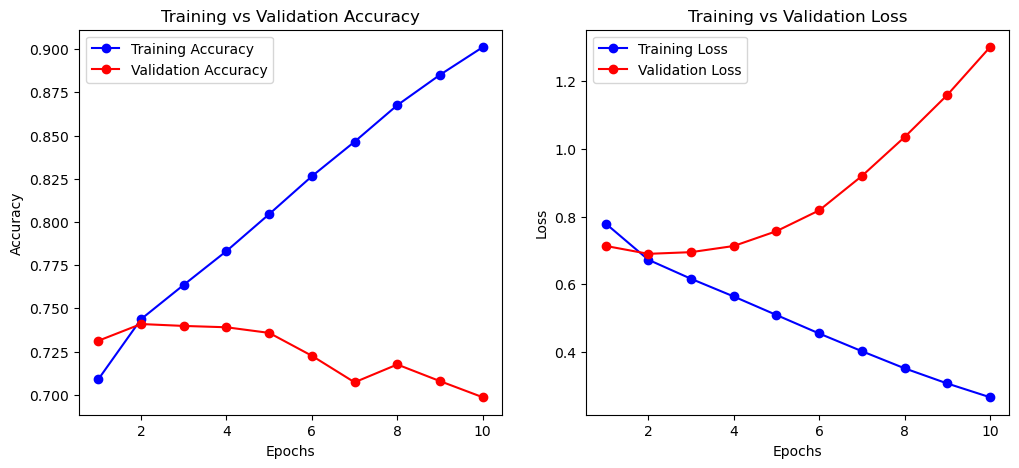

In [41]:
import matplotlib.pyplot as plt

# Extract accuracy and loss from training history
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_acc) + 1)

# Plot accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'bo-', label="Training Accuracy")
plt.plot(epochs, val_acc, 'ro-', label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'bo-', label="Training Loss")
plt.plot(epochs, val_loss, 'ro-', label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")

plt.show()
